# Similaridade de projetos - engenharia de features

Issue: [#244](https://github.com/lappis-unb/salic-ml/issues/244)

## Objetivos

Documentar a Engenharia de Features para Similaridade de projetos. A similaridade aqui é em termos de estrutura: quais itens, segmentos e áreas.

### Features

- Segmento
- Area
- Produtos culturais. Considerar apenas idProduto != 0, pois idProduto são itens de "administração de projeto" como: refeição, hospedagem, passagem aérea, postagem, contador, combustível, salário

pronac = '143251'

**Considerando os produtos**

1 - produtos

2 - produtos, segmento

3 - produtos, area, segmento

É importante considerar que se os segmentos são iguais, a probabilidade das áreas serem iguais é quase 1 (`(s - 1) / s`, onde `s = numero_de_segmentos`)

**Considerando os itens**

1 - conjunto de itens (id de itens)

2 - conjunto de itens, segmento

3 - conjunto de itens, área, segmento


### Algoritmos

1 - [Jaccard index](https://en.wikipedia.org/wiki/Jaccard_index)

2 - Jaccard index com pesos

3 - [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)

---
## Preparação

**Dataset sql**

`projects_similarity.sql`

Breve descrição de quais dados serão lidos e utilizados. A partir daqui, todas as seções devem ser iniciadas por uma barra horizontal (3 hífens, conforme a linha 1 desta célula), seguido de um header 2 (##) com o nome da seção e então a descrição da seção. As demais subseções devem ser declaradas com um header 4 (####) seguido de uma descrição, que é opcional.

Abaixo é mostrado um exemplo de utilização da seção de preparação.

#### Importando módulos e definindo constantes

In [1]:
%pylab inline
import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from core.utils.read_csv import read_csv

Populating the interactive namespace from numpy and matplotlib


#### Carregando e mostrando dataset a ser utilizado ao longo do estudo

In [2]:
planilha_name = 'planilha_orcamentaria_similaridade.csv'
df = read_csv(planilha_name)
display(df.dtypes)
df.head()

idPronac                int64
PRONAC                  int64
idPlanilhaAprovacao     int64
Item                   object
idPlanilhaItens         int64
idArea                  int64
Area                   object
idSegmento             object
Segmento               object
idProduto               int64
Produto                object
DataProjeto            object
dtype: object

,idPronac,PRONAC,idPlanilhaAprovacao,Item,idPlanilhaItens,idArea,Area,idSegmento,Segmento,idProduto,Produto,DataProjeto
0,114409,93242,37560,Remuneração para captação de recursos,5249,5,Patrimônio Cultural,51,História,0,Administracao do Projeto,2009-07-03 09:06:13
1,133865,110662,170118,"Seguro (pessoas, obras e equipamentos - especi...",201,3,Música,34,Áreas Integradas,0,Administracao do Projeto,2011-01-25 08:47:38
2,118623,97348,296587,"Seguro (pessoas, obras e equipamentos - especi...",201,5,Patrimônio Cultural,59,Artesanato/Folclore,0,Administracao do Projeto,2009-11-11 09:44:14
3,139598,116152,297365,Coordenação geral,3677,1,Artes Cênicas,11,Teatro,0,Administracao do Projeto,2011-07-11 10:57:08
4,171367,1311323,1125134,Remuneração para captação de recursos,5249,6,Humanidades,6C,Livros ou obras de referência - valor Artístico,0,Administracao do Projeto,2013-12-05 10:57:54


### Extraindo features de produto

**Features**:

- idSegmento

- idArea

- produtos

In [3]:
PRODUCT_COLUMNS = ['PRONAC', 'idPronac', 'idSegmento', 'idArea', 'idProduto', 'idPlanilhaItens']
df_products = df[df['idProduto'] != 0]
df_products = df_products[PRODUCT_COLUMNS]

display(df_products.head())

,PRONAC,idPronac,idSegmento,idArea,idProduto,idPlanilhaItens
5,110667,133870,11,1,132,2743
6,110667,133870,11,1,132,178
15,110667,133870,11,1,132,201
19,112030,135253,41,4,100,3677
24,91102,112234,71,7,113,176


In [4]:
products_group = df_products.groupby(['PRONAC'])

for pronac, group in products_group:
    id_segmento = group.iloc[0]['idSegmento']
    id_area = group.iloc[0]['idArea']
    id_pronac = group.iloc[0]['idPronac']
    products_unique = group.idProduto.unique()
    products = group.idProduto.values
    
    print('PRONAC = {}'.format(pronac))
    print('idPronac = {}'.format(id_pronac))
    print('id_segmento = {}'.format(id_segmento))
    print('id_area = {}'.format(id_area))
    print('products_unique = {}'.format(products_unique))
    print('products = {}'.format(products))

    
    break

PRONAC = 90105
idPronac = 111218
id_segmento = 11
id_area = 1
products_unique = [19]
products = [19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19
 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19
 19 19 19 19 19 19 19]


### Segmentos mais comuns

In [5]:
popular_segments = df[['PRONAC', 'idSegmento', 'idArea']].groupby(['PRONAC', 'idSegmento']).count()
popular_segments = popular_segments.groupby('idSegmento').count().sort_values(by='idArea', ascending=False)
display(popular_segments.head())

,idArea
idSegmento,
11,9793
31,4551
33,4338
4B,2659
12,2415


# Distribuição do número de produtos por projeto

A média do número de produtos culturais é de 2.5, portanto utilizar a similaridade de Jaccard apenas nestas features enviesa os resultados: muitos projetos serão muito parecidos.

count    41616.000000
mean         2.548227
std          0.957027
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         16.000000
Name: idProduto, dtype: float64

(array([2.7116e+04, 9.3010e+03, 4.4870e+03, 3.7800e+02, 2.6700e+02,
        3.5000e+01, 2.6000e+01, 2.0000e+00, 3.0000e+00, 1.0000e+00]),
 array([ 1. ,  2.5,  4. ,  5.5,  7. ,  8.5, 10. , 11.5, 13. , 14.5, 16. ]),
 <a list of 10 Patch objects>)

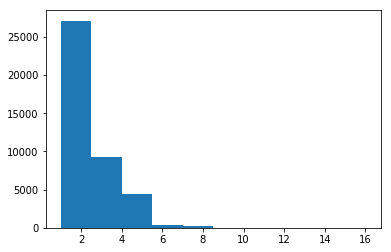

In [6]:
nunique_products = df[['PRONAC', 'idProduto']].groupby('PRONAC').nunique()
display(nunique_products['idProduto'].describe())
plt.hist(nunique_products.idProduto.values)

# Features: (idSegmento, idArea, [produtos])

In [7]:
def jaccard_collections_similarity(a, b):
    '''Assumes that all sets in a are disjoint, as well as all sets in b'''
    assert isinstance(a, list)
    assert isinstance(b, list)
    assert len(a) == len(b)

    intersects = [np.intersect1d(a[i], b[i]).size for i in range(len(a))]
    unions = [np.union1d(a[i], b[i]).size for i in range(len(a))]
    return sum(intersects) / sum(unions)

def jaccard_similarity(a, b):
    intesect_size = np.intersect1d(a, b).size
    union_size = np.union1d(a, b).size
    return intesect_size / union_size

def simple_similarity(a, b):
    return 1 if a == b else 0

display(jaccard_collections_similarity([[1, 2], [3, 5, 7]], [[2], [5, 7]]))
display(jaccard_similarity([1, 2, 5], [5, 2]))
display(simple_similarity(5, 5))

0.6

0.6666666666666666

1

In [8]:
def get_products_features(pronac):
    group = products_group.get_group(pronac)
    id_segmento = group.iloc[0]['idSegmento']
    id_area = group.iloc[0]['idArea']
    products = group.idProduto.unique()
    features = {
        'id_segmento': id_segmento,
        'id_area': id_area,
        'products': products,
    }
    return features

display(get_products_features(110667))

{'id_segmento': '11', 'id_area': 1, 'products': array([132])}

In [9]:
def get_products_items_features(pronac):
    group = products_group.get_group(pronac)
    id_segmento = group.iloc[0]['idSegmento']
    id_area = group.iloc[0]['idArea']
    products = group.idProduto.unique()
    
    features = {
        'id_segmento': [id_segmento],
        'id_area': [id_area],
        'product': products,
        'items': group.idPlanilhaItens.unique()
    }
    
    #group_product = group.groupby(['idProduto'])
    #for id_produto, rows in group_product:
        #id_items = rows['idPlanilhaItens'].unique()
        #features['product'][id_produto] = id_items
    return features

display(get_products_items_features(110667))

{'id_segmento': ['11'],
 'id_area': [1],
 'product': array([132]),
 'items': array([2743,  178,  201, 4882, 3235,  134, 2574, 3546, 3677,  144, 3745,
        2611, 3650,   88,  150, 3097, 2726, 1129,  129,  179,   53, 2357,
        3740, 1119])}

In [10]:
def pronacs_similarity(pronac1, pronac2):
    features = [get_products_features(pronac) for pronac in [pronac1, pronac2]]
    sim = jaccard_collections_similarity(list(features[0].values()), 
                             list(features[1].values()))
    return sim

def debug_similarity(pronac1, pronac2):
    sim = pronacs_similarity(pronac1, pronac2)
    print('features1 = {}'.format(get_products_features(pronac1)))
    print('features2 = {}'.format(get_products_features(pronac2)))
    print('sim(pronac1, pronac2) = {}'.format(sim))
    
pronacs = df[df['idSegmento'] == '11']['PRONAC'].unique()
display(pronacs)

pronac1, pronac2 = pronacs[0], pronacs[1]
debug_similarity(pronac1, pronac2)

array([116152, 110667, 143348, ..., 163585, 163598, 163609])

features1 = {'id_segmento': '11', 'id_area': 1, 'products': array([19])}
features2 = {'id_segmento': '11', 'id_area': 1, 'products': array([132])}
sim(pronac1, pronac2) = 0.5


In [11]:
def pronacs_products_similarity(pronac1, pronac2):
    features = [get_products_items_features(pronac) for pronac in [pronac1, pronac2]]
    #for i in range(2):
        #print('features[{}] = {}\n'.format(i, features[i]))
        
    similarity = 0.0
    items_1 = features[0]['items']
    items_2 = features[1]['items']
    
    items_union_size = np.union1d(items_1, items_2).size
    items_intersection_size = np.intersect1d(items_1, items_2).size
    items_symmetric_difference = items_union_size - items_intersection_size
    
    for key, values in features[0].items():
        weight = 1
        if key in ['id_segmento', 'id_area']:
            weight = 1.0 / (1 + items_symmetric_difference)
            
        sim = jaccard_similarity(values, features[1][key])   
        similarity += (sim * weight)
    return similarity
        

pronac1, pronac2 = pronacs[0], pronacs[1]
sim = pronacs_products_similarity(pronac1, pronac2)
print('pronacs_products_similarity(1, 2) = {}'.format(sim))

pronacs_products_similarity(1, 2) = 0.07409694350108058


In [29]:
def find_top5(pronac, pronac_sample): 
    similarities = []
    
    for i, pronac2 in enumerate(pronac_sample):
        if pronac2 != pronac:
            sim = pronacs_products_similarity(pronac, pronac2)
            similarities.append((sim, pronac2))
    return sorted(similarities, reverse=True)[:5]

pronac = 138478
pronac_sample = df[df['idSegmento'] == '4B'].PRONAC.unique()
print('pronac_sample = {}'.format(pronac_sample))
print('features(pronac={}) = {}'.format(pronac, get_products_items_features(pronac)))
print('top5(pronac={}) = {}'.format(pronac, find_top5(pronac, pronac_sample)))

pronac_sample = [131246 159308 127946 ... 178773 171419 164187]
features(pronac=138478) = {'id_segmento': ['4B'], 'id_area': [4], 'product': array([121,  62,  50,   2,  16, 115,  81,  11,  27,   3,  67,  38,   8]), 'items': array([ 130, 2621, 1044,   60, 3293, 5108, 3740, 2440, 3662, 1219,  114,
       3553, 1106,   95, 1036, 3624, 3539, 3743, 2622, 1133, 1159,  150,
       3678, 2740, 2699, 2764,  131, 4813,   92, 2759, 3567, 3537,   57,
       3751, 4019,  143, 3566, 3544, 3584, 2813, 3631, 2755, 1119, 2438,
       3546,  134, 1006, 2692, 1129, 3504, 2694, 2645, 1145, 3570, 1164,
        179, 1072,  109, 1013, 3578, 3840,   14, 4111, 2756, 4612, 1019,
       3592, 1043, 1161,   58, 1111, 3591, 2719, 2766, 3736, 3538, 1162,
       3531, 2781, 2713,  142, 4418, 1120,   40, 1093, 3715, 3684, 3532,
       2439, 4811,   20,   13, 3598, 4398,   91,   43,  118, 1008, 1037,
         76,   41, 2601, 1048, 3745,  201, 3947, 2584, 2711, 2726, 3530,
        103, 4557, 3124, 3671, 2138, 1169,  14

In [ ]:
df.groupby(['PRONAC', 'idProduto']).count().groupby(['PRONAC']).count().sort_values('idPronac', ascending=False)

---
## Desenvolvimento

Explicação de o que será explorado. Se necessário, quebrar o desenvolvimento em tópicos.

---
## Resultados e Conclusões

Apresentação dos resultados de desempenho, precisão, acurácia, análise dos gráficos e algoritmos.

Por fim, discussão do que foi implementado e apresentação das melhores alternativas de algoritmos e tecnologias, além de um possível levantamento de trabalhos futuros.